In [1]:
# Import libraries
import pandas as pd
import os
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import re
import math
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from sklearn import preprocessing
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import LabelEncoder 
from sklearn.feature_selection import SequentialFeatureSelector

from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from lightgbm import LGBMClassifier
import xgboost
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Conv2D, BatchNormalization
from tensorflow.keras.layers import Activation, MaxPool2D, Flatten, Dropout, Dense
from tensorflow.keras.layers import Activation, MaxPool2D, Flatten, Dropout, Dense
from keras.models import Sequential
from imblearn.over_sampling import RandomOverSampler, SMOTE


In [2]:
os.chdir("C:\\MS in Data Science\\IIT\\Courses\\MATH 569 - Statistical Learning\\Project\\Dataset")

In [3]:
# Load the data. train.csv will be split into training and test sets.
data = pd.read_csv("train.csv")


# Scores dataset contains the goals scored in each match
scores = pd.read_csv("train_target_and_scores.csv")
scores.columns

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Index(['id', 'score', 'target'], dtype='object')

In [4]:
# Entropy calculation
arr = (data.groupby('target')['id'].count()/data.shape[0]).values
entropy = 0
for i in range(len(arr)):
    entropy = entropy + arr[1]*math.log(arr[1])
print(-1*entropy)

1.0388451087091


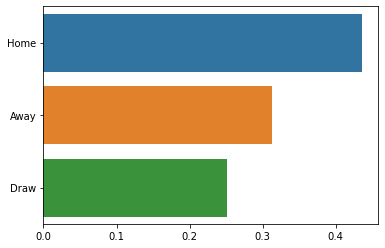

In [13]:
# Graph showing the split of the response variable
gr1 = data['target'].value_counts()/data.shape[0]
sns.barplot(x=gr1.values, y=['Home', 'Away', 'Draw'])
plt.show()

In [6]:
# Remove Nulls
print(data.shape)
data = data.dropna(subset=data.columns[10:20], how='all', thresh=5)
print(data.shape)

# Fill NAs
data = data.fillna(value=0)

# Modify values in columns
data['is_cup'] = np.where(data['is_cup']==False,0,1)

(104461, 190)
(104461, 190)


In [7]:
# Convert date fields
for col in data.columns:
    if 'match_date' in col:
        #print(col)
        data[col] = pd.to_datetime(data[col])

In [8]:
# Generate new features and drop unnecessary features
# Note: Home and away represent the current match teams
# Note: 'opp' is used to get the historical opponent team statistics for the home/away team (current match) respectively
# Note: when 'history' is present in a feature, it represents historical matches
def generate_features(df, drop_names=True):
    # Get total goals & opponent total goals in the 10 historical matches for home and away teams
    for home_away in ['home', 'away']:
        total_goals = df.loc[:,[col for col in df.columns if (home_away + '_team_history_goal_') in col]].sum(axis=1)
        total_goals_opp = df.loc[:,[col for col in df.columns if (home_away + '_team_history_opponent_goal_') in col]].sum(axis=1)
        df.loc[:,home_away + '_team_hist_goals'] = total_goals
        df.loc[:,home_away + '_team_hist_goals_opp'] = total_goals_opp
    
    
    # Generate other features for both home and away team
    for home_away in ['home', 'away']:
        df[home_away + '_streak'] = 0
        for j in range(1,11):
            # Home/away team wins
            df[home_away + '_team_hist_wins_' + str(j)] = np.where(df[home_away + '_team_history_goal_' + str(j)] > df[home_away + '_team_history_opponent_goal_' + str(j)], 1,0)
            
            # Home/away team wins when its respective rating is greater
            df[home_away + '_team_hist_rating_gr_wins_' + str(j)] = np.where((df[home_away + '_team_history_rating_' + str(j)] > df[home_away + '_team_history_opponent_rating_' + str(j)]) & (df[home_away + '_team_hist_wins_' + str(j)] ==1), 1,0)
            
            # Home/away team draws
            df[home_away + '_team_hist_draws_' + str(j)] = np.where(df[home_away + '_team_history_goal_' + str(j)] == df[home_away + '_team_history_opponent_goal_' + str(j)], 1,0)
            
            # Home/away team draws when its respective rating is greater
            df[home_away + '_team_hist_rating_gr_draws_' + str(j)] = np.where((df[home_away + '_team_history_rating_' + str(j)] == df[home_away + '_team_history_opponent_rating_' + str(j)]) & (df[home_away + '_team_hist_draws_' + str(j)] ==1), 1,0)
            
            # Home/away team wins & draws when match is not a cup match
            df[home_away + '_team_hist_not_cup_wins_' + str(j)] = np.where((df[home_away + '_team_hist_wins_' + str(j)] ==1) & (df[home_away + '_team_history_is_cup_' + str(j)] ==1), 1,0)
            df[home_away + '_team_hist_not_cup_draws_' + str(j)] = np.where((df[home_away + '_team_hist_draws_' + str(j)] ==1) & (df[home_away + '_team_history_is_cup_' + str(j)] ==1), 1,0)

            # wins at home/away for home/away respectively (since home is playing at home and away is playing away)
            if home_away == 'home':
                df[home_away + '_team_hist_wins_home_' + str(j)] = np.where((df[home_away + '_team_hist_wins_' + str(j)] ==1) & (df[home_away + '_team_history_is_play_home_' + str(j)] ==1),1,0)
            else:
                df[home_away + '_team_hist_wins_away_' + str(j)] = np.where((df[home_away + '_team_hist_wins_' + str(j)] ==1) & (df[home_away + '_team_history_is_play_home_' + str(j)] ==0),1,0)

            # draws at home/away for home/away respectively
            if home_away == 'home':
                df[home_away + '_team_hist_draws_home_' + str(j)] = np.where((df[home_away + '_team_hist_draws_' + str(j)] ==1) & (df[home_away + '_team_history_is_play_home_' + str(j)] ==1),1,0)
            else:
                df[home_away + '_team_hist_draws_away_' + str(j)] = np.where((df[home_away + '_team_hist_draws_' + str(j)] ==1) & (df[home_away + '_team_history_is_play_home_' + str(j)] ==0),1,0)
            
            # Detting days difference from match date for the historical matches
            df[home_away + '_team_hist_match_date_diff_' + str(j)] = (df[home_away + '_team_history_match_date_' + str(j)] - df['match_date'])/np.timedelta64(1,'D')
            
            # Win streak for home/away teams
            df[home_away + '_streak'] = np.where(((df[home_away + '_team_hist_wins_' + str(j)]==0) | (df[home_away + '_team_hist_draws_' + str(j)]==1)) & (j>df[home_away + '_streak']), j, df[home_away + '_streak'])
        
            
        # Hist wins, rating > wins & not cup wins (Aggregating)
        df[home_away + '_team_hist_wins'] = df.loc[:,[col for col in df.columns if (home_away+'_team_hist_wins_') in col]].sum(axis=1)
        df[home_away + '_team_hist_wins_rating_gr'] = df.loc[:,[col for col in df.columns if (home_away+'_team_hist_rating_gr_wins_') in col]].sum(axis=1)
        df[home_away + '_team_hist_wins_not_cup']  = df.loc[:,[col for col in df.columns if (home_away+'_team_hist_not_cup_wins_') in col]].sum(axis=1)
        
        # Hist draws, rating > draws & not cup draws  (Aggregating)
        df[home_away + '_team_hist_draws'] = df.loc[:,[col for col in df.columns if (home_away+'_team_hist_draws_') in col]].sum(axis=1)
        df[home_away + '_team_hist_draws_rating_gr'] = df.loc[:,[col for col in df.columns if (home_away+'_team_hist_rating_gr_draws_') in col]].sum(axis=1)
        df[home_away + '_team_hist_draws_not_cup']  = df.loc[:,[col for col in df.columns if (home_away+'_team_hist_not_cup_draws_') in col]].sum(axis=1)
        
        # Hist Home & Away - wins & draws (Aggregating)
        if home_away == 'home':
            df[home_away + '_team_hist_wins_home'] = df.loc[:,[col for col in df.columns if (home_away+'_team_hist_wins_home_') in col]].sum(axis=1)
        else:
            df[home_away + '_team_hist_wins_away'] = df.loc[:,[col for col in df.columns if (home_away+'_team_hist_wins_away_') in col]].sum(axis=1)

        if home_away == 'home':
            df[home_away + '_team_hist_draws_home'] = df.loc[:,[col for col in df.columns if (home_away+'_team_hist_draws_home_') in col]].sum(axis=1)
        else:
            df[home_away + '_team_hist_draws_away'] = df.loc[:,[col for col in df.columns if (home_away+'_team_hist_draws_away_') in col]].sum(axis=1)
        
        # Coach change for home/away team
        df[home_away+'_coach_change'] = df[[col for col in df.columns if (home_away + '_team_history_coach') in col]].nunique(axis=1)
        df[home_away+'_coach_change'] = np.where(df[home_away+'_coach_change'] >1,1,0)
        
        # Hist Cup matches played for home/away team
        df[home_away + '_cup_matches'] =df.loc[:,[col for col in df.columns if (home_away + '_team_history_is_cup_') in col]].sum(axis=1)
        
        #df[home_away+'_league_change'] = df[[col for col in df.columns if (home_away + '_team_history_league_id_') in col]].nunique(axis=1)
        #df[home_away+'_league_change'] = np.where((df[home_away+'_league_change'])==1 and (df[home_away + '_cup_matches'])==0,0,1)
        #df[home_away+'_league_change'] = np.where((df[home_away+'_league_change'])==2 and (df[home_away + '_cup_matches'])>0,0,1)
        
        # team has win/not win info as 1,1,1,0,0,1,0,1,1,1. First we get the last 0, then we do 10 - position(last 0) to get streak
        df[home_away + '_streak'] = 10 - df[home_away + '_streak']
        
    #df['transfer_window_flag'] = np.where(pd.DatetimeIndex(data['match_date']).month between )  
        
    # The below line is commented out to get the 347 feature dataset
    df = df.drop([col for col in df.columns if bool(re.search(r'\d', col))], axis=1)
    #df = df.drop([col for col in df.columns if 'match_date_' in col], axis=1)
    #df = df.drop([col for col in df.columns if '_league_id' in col], axis=1)
    #df = df.drop([col for col in df.columns if 'history_coach' in col], axis=1)
    
    # Below features were correlated but removing them did not improve the accuracy
    """
    df = df.drop(['home_team_hist_goals', 
             'home_team_hist_wins',
              'home_team_hist_wins_rating_gr',
              'home_team_hist_draws',
              
              'away_team_hist_goals',
              'away_team_hist_wins',
              'away_team_hist_draws',
              'away_team_hist_draws_rating_gr',
                'home_team_hist_wins_not_cup',
                  'away_team_hist_wins_not_cup'
             ], axis=1)
    """
    
    # Drop variables that cannot be used in the model
    if drop_names==True:
        df = df.drop(['id', 'away_team_name', 'match_date', 'league_name', 'league_id',
                               'home_team_coach_id', 'home_team_name', 'away_team_coach_id'
                               ], axis=1)
    return(df)

In [ ]:
# This is the original dataset with non trainable features removed
# We will use this dataset as well, especially for neural networks as this dataset worked better
def no_conversion(df):
    df = df.drop([col for col in df.columns if 'match_date_' in col], axis=1)
    df = df.drop([col for col in df.columns if '_league_id' in col], axis=1)
    df = df.drop([col for col in df.columns if 'history_coach' in col], axis=1)
    
    df = df.drop(['id', 'away_team_name', 'match_date', 'league_name', 'league_id',
                               'home_team_coach_id', 'home_team_name', 'away_team_coach_id'
                               ], axis=1)
    return(df)

In [11]:
# Generate the new features and convert them (basically aggregating historical information). Converted dataset with 28 features
df = data.copy()
df = generate_features(df)
df.shape

(104461, 28)

In [12]:
# Dropping is_cup = 1 rows and then dropping the column (as cup data is noisy)
df = df[df["is_cup"]==0]
df = df.drop("is_cup", axis=1)

<AxesSubplot:>

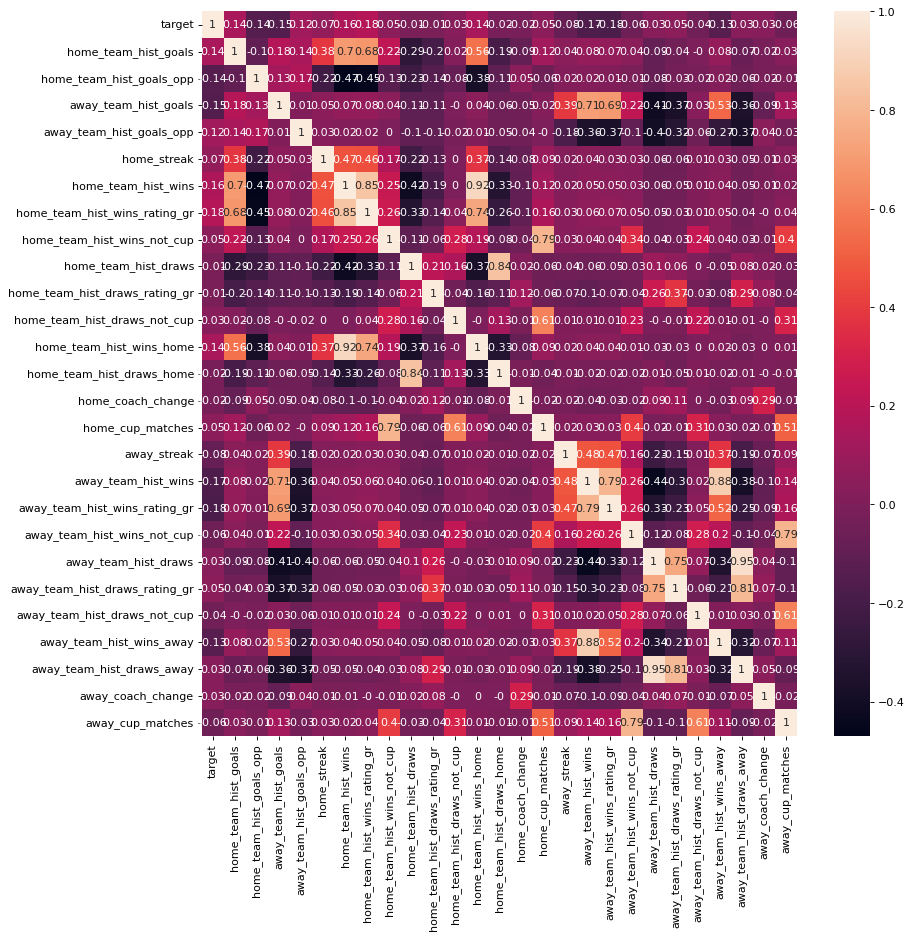

In [14]:
# Correlation matrix to identify correlated variables
df2 = df.copy()
df2['target'] = np.where(df2['target']=='home', 3, df2['target'])
df2['target'] = np.where(df2['target']=='draw', 1, df2['target'])
df2['target'] = np.where(df2['target']=='away', 0, df2['target'])
df2['target'] = df2['target'].astype(int)
df2.head()
mat = df2.corr(method='pearson').round(2)
plt.figure(figsize=(12, 12), dpi=80)
sns.heatmap(mat, annot=True)

In [16]:
# Test Train Split
# Split by date (dataset is already ordered by date)
index = int(0.8*df.shape[0])
train = df.iloc[0:(index),:]
test = df.iloc[index:,:]
X_train = train.drop('target', axis=1)
y_train = train['target']
X_test = test.drop('target', axis=1)
y_test = test['target']
print(X_train.shape, X_test.shape)

(76895, 26) (19224, 26)


In [ ]:
# OverSampling (Not used to get the final results)
oversample = RandomOverSampler(sampling_strategy='auto')
X_over, y_over = oversample.fit_resample(X_train, y_train)
print(X_over.shape, y_over.shape)
X_train = X_over.copy()
y_train = y_over.copy()

In [ ]:
# Scaling (Not used to get the final results)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
scaler = preprocessing.StandardScaler().fit(X_test)
X_test = scaler.transform(X_test)

In [20]:
# Logistic Regression (Linear model)
# Basic model

model = LogisticRegression(multi_class='multinomial', solver='saga', max_iter=500, penalty='elasticnet', l1_ratio=0.1)
model.fit(X_train, y_train)

# Predict
yhat_logit = model.predict(X_test)
print("testing error: ", accuracy_score(y_test, yhat_logit))
print(confusion_matrix(y_test, yhat_logit))
#class_dict = {'away':0.3, 'draw':0.4, 'home':0.3}
yhat_logit_train = model.predict(X_train)
print("training error: ", accuracy_score(y_train, yhat_logit_train))

testing error:  0.4928214731585518
[[2702   50 3209]
 [1478   43 3479]
 [1499   35 6729]]
training error:  0.4900188568827622


In [ ]:
# Much faster way to run Logistic regression (regularization is tricky though)
logit = sm.MNLogit(y_train, sm.add_constant(X_train)).fit(method='newton', maxiter=1000)
yhat = logit.predict(sm.add_constant(X_test))
pred = np.argmax(np.array(yhat), axis=1)
pred = np.where(pred==0, "away", pred)
pred = np.where(pred=='1', "draw", pred)
pred = np.where(pred=='2', "home", pred)
print("test error: ", accuracy_score(np.array(y_test), pred))
logit.summary()

In [ ]:
# Hyperparameter tuning for Logistic regression
# Get best alpha
acc_list = []
for i in np.arange(0,1, 0.1):
    print(i)
    model = LogisticRegression(multi_class='multinomial', solver='saga', max_iter=500, penalty='elasticnet', l1_ratio=i)
    model.fit(X_train, y_train)

    # Predict
    yhat_logit = model.predict(X_test)
    acc_list.append([i, accuracy_score(y_test, yhat_logit)])
    print(i, accuracy_score(y_test, yhat_logit))

In [21]:
# Random Forests (Bagging model)

# Hyperparameter tuning using Grid Search
param_grid = {"criterion": ['gini', 'entropy'],
             "n_estimators": [200,400],
              "min_samples_leaf": [40],
              "max_depth": [3,5,7],
                "max_features": [None, 'auto']
              }
rf = RandomForestClassifier(n_jobs=4, max_features=None)
gs = GridSearchCV(
    estimator=rf, 
    param_grid=param_grid,
    cv=3,
    refit=True,
    verbose=True,
    n_jobs=4)
gs.fit(X_train, y_train)
gs.best_params_

rf = RandomForestClassifier(max_depth=7, 
                            random_state=4, 
                            min_samples_leaf=40, 
                            n_jobs=4,
                            n_estimators=400,
                            criterion='gini'
                           )
rf.fit(X_train.values, y_train.values)
yhat_rf = rf.predict(X_test)
print("Testing Error: ", accuracy_score(y_test, yhat_rf))
yhat_rf_train = rf.predict(X_train)
print("Training Error: ", accuracy_score(y_train, yhat_rf_train))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Testing Error:  0.48564294631710364


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Training Error:  0.4899018141621692


In [ ]:
# XGBoost (Boosting model)

# Hyperparameter tuning
param_grid = {"learning_rate": [0.01,0.05, 0.1],
             "n_estimators": [200,400],
              "num_leaves": [3,5,10],
              "min_data_in_leaf": [40],
              "max_depth": [3,5,7]
              }
gs = GridSearchCV(
    estimator=xgb, 
    param_grid=param_grid,
    cv=3,
    refit=True,
    verbose=True,
    n_jobs=4)
gs.fit(X_train, y_train)
gs.best_params_


In [23]:
xgb = xgboost.XGBClassifier(objective='multiclass', eval_metric='mlogloss', n_jobs=4, random_state=4,
                            # Best parameters obtained from hyperparameter tuning
                           learning_rate=0.1,
                            max_depth=3,
                            min_data_in_leaf=40,
                            n_estimators=200,
                            num_leaves=3
                           )
xgb.fit(X_train, y_train)
yhat_xgb = xgb.predict(X_test)
print("Testing Error: ", accuracy_score(y_test, yhat_xgb))

yhat_xgb_train = xgb.predict(X_train)
print("Training Error:", accuracy_score(y_train, yhat_xgb_train))

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:27:54] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_data_in_leaf", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Testing Error:  0.48892009987515606
Training Error: 0.4935951622342155


In [ ]:
# LightGBM (not discussed in PDF. XGBoost is used instead)
lgbm = LGBMClassifier(objective='multiclass', random_state=5, n_jobs=4)
lgbm.fit(X_train, y_train)
yhat_lgbm = lgbm.predict(X_test)
accuracy_score(y_test, yhat_lgbm)

In [ ]:
# Linear SVM  (not discussed in PDF)
svm = LinearSVC(fit_intercept =False, max_iter=1000)
svm.fit(X_train, y_train)
yhat_svm = svm.predict(X_test)
accuracy_score(y_test, yhat_svm)

In [24]:
# Neural Networks - Multilayer Perceptron
# Using the dataset without feature conversion gave the best results
label = LabelEncoder()
y_train_enc = label.fit_transform(y_train)
nn = Sequential()
nn.add(Dense(100, input_dim=X_train.shape[1], activation='relu'))
nn.add(Dropout(0.2))
nn.add(Dense(30, activation='relu'))

nn.add(Dense(14, activation='relu'))
#nn.add(Dropout(0.1))
nn.add(Dense(7, activation='relu'))
#nn.add(Dropout(0.3))
nn.add(Dense(3, activation='softmax'))
nn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics='accuracy')
nn.fit(X_train.values, y_train_enc, verbose=1, epochs=50) # 30 epochs was optimal


yhat_nn = nn.predict(X_test)
pred_nn = np.argmax(yhat_nn, axis=-1).astype('int')
pred_nn = np.where(pred_nn==0, "away", pred_nn)
pred_nn = np.where(pred_nn=='1', "draw", pred_nn)
pred_nn = np.where(pred_nn=='2', "home", pred_nn)
print("testing error: ", accuracy_score(y_test, pred_nn))


yhat_nn_train = nn.predict(X_train)
pred = np.argmax(yhat_nn_train, axis=-1).astype('int')
pred = np.where(pred==0, "away", pred)
pred = np.where(pred=='1', "draw", pred)
pred = np.where(pred=='2', "home", pred)
print("training error: ", accuracy_score(y_train, pred))


Epoch 1/50
2403/2403 [==============================] - 3s 1ms/step - loss: 1.0400 - accuracy: 0.4775
Epoch 2/50
2403/2403 [==============================] - 2s 1ms/step - loss: 1.0281 - accuracy: 0.4846
Epoch 3/50
2403/2403 [==============================] - 2s 1000us/step - loss: 1.0258 - accuracy: 0.4856
Epoch 4/50
2403/2403 [==============================] - 2s 994us/step - loss: 1.0255 - accuracy: 0.4867
Epoch 5/50
2403/2403 [==============================] - 2s 1ms/step - loss: 1.0250 - accuracy: 0.4881
Epoch 6/50
2403/2403 [==============================] - 2s 1ms/step - loss: 1.0245 - accuracy: 0.4870
Epoch 7/50
2403/2403 [==============================] - 2s 1ms/step - loss: 1.0240 - accuracy: 0.4873
Epoch 8/50
2403/2403 [==============================] - 2s 1000us/step - loss: 1.0238 - accuracy: 0.4872
Epoch 9/50
2403/2403 [==============================] - 2s 992us/step - loss: 1.0234 - accuracy: 0.4881
Epoch 10/50
2403/2403 [==============================] - 2s 1ms/step - l

In [25]:
# Naive Bayes
nb = MultinomialNB()
nb.fit(X_train, y_train)
yhat_nb = nb.predict(X_test)
print("testing error: ", accuracy_score(y_test, yhat_nb))
yhat_nb_train = nb.predict(X_train)
print("training error: ", accuracy_score(y_train, yhat_nb_train))

testing error:  0.4715459841864336
training error:  0.46819689186553093


In [26]:
# LDA 
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
yhat_lda = lda.predict(X_test)
print("testing error: ", accuracy_score(y_test, yhat_lda))
yhat_lda_train = lda.predict(X_train)
print("training error: ", accuracy_score(y_train, yhat_lda_train))

testing error:  0.49245734498543486
training error:  0.49018791859028543


In [27]:
# QDA
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)
yhat_qda = qda.predict(X_test)
print("testing error: ", accuracy_score(y_test, yhat_qda))
yhat_qda_train = qda.predict(X_train)
print("training error: ", accuracy_score(y_train, yhat_qda_train))

testing error:  0.46821681231793594
training error:  0.4653618570778334


In [28]:
# Ensemble (gave very low accuracy scores and hence scores are not reported in pdf)
# Compute predicted probabilites of different models
pred_proba_logit = pd.DataFrame(model.predict_proba(X_test), columns=['home', 'draw', 'away'])
pred_proba_rf = pd.DataFrame(rf.predict_proba(X_test), columns=['home', 'draw', 'away'])
pred_proba_xgb = pd.DataFrame(xgb.predict_proba(X_test), columns=['home', 'draw', 'away'])
pred_proba_nb = pd.DataFrame(nb.predict_proba(X_test), columns=['home', 'draw', 'away'])
pred_proba_lda = pd.DataFrame(lda.predict_proba(X_test), columns=['home', 'draw', 'away'])

# Function to get higher predicted probability among 2 dataframes
def get_higher_prob(df1, df2):
    for row in range(df1.shape[0]):
        for col in range(df1.shape[1]):
            #print(df1.iloc[row,col], df2.iloc[row,col])
            if df1.iloc[row,col] < df2.iloc[row,col]:
                #print("True")
                df1.iloc[row,col] = df2.iloc[row,col]
    return(df1)

# Get the highest predicted probability for all the models
pred_proba_ensemble = pred_proba_logit.copy()
pred_proba_ensemble = get_higher_prob(pred_proba_ensemble, pred_proba_rf)
pred_proba_ensemble = get_higher_prob(pred_proba_ensemble, pred_proba_xgb)
#Naive Bayes had higher probabilities and hence removed
#pred_proba_ensemble = get_higher_prob(pred_proba_ensemble, pred_proba_nb)
pred_proba_ensemble = get_higher_prob(pred_proba_ensemble, pred_proba_lda)
yhat_ensemble_max = pred_proba_ensemble.idxmax(axis=1)
print(accuracy_score(y_test, yhat_ensemble_max))
pd.DataFrame(confusion_matrix(y_test, yhat_ensemble_max))

# Function to get sum of probabilities
def get_sum_prob(df1, df2):
    for col in df1.columns:
        df1[col] = df1[col] + df2[col]
    return(df1)

# Get the average of the probabilities
pred_proba_ensemble_mean = pred_proba_logit.copy()
pred_proba_ensemble_mean = get_sum_prob(pred_proba_ensemble_mean, pred_proba_rf)
pred_proba_ensemble_mean = get_sum_prob(pred_proba_ensemble_mean, pred_proba_xgb)
#Naive Bayes had higher probabilities and hence removed
#pred_proba_ensemble_mean = get_sum_prob(pred_proba_ensemble_mean, pred_proba_nb)
pred_proba_ensemble_mean = get_sum_prob(pred_proba_ensemble_mean, pred_proba_lda)
for col in pred_proba_ensemble_mean.columns:
    pred_proba_ensemble_mean[col] = pred_proba_ensemble_mean[col]/4
yhat_ensemble_mean = pred_proba_ensemble_mean.idxmax(axis=1)
pd.DataFrame(confusion_matrix(y_test, yhat_ensemble_mean))
pred_proba_ensemble_mean.head()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


0.2506762380357886


,0,1,2
0,3393,20,2548
1,3639,15,1346
2,6871,9,1383


In [ ]:
# Other Codes

# For Binary classification
df['target'] = np.where(df['target']=='draw', 'away', df['target'])


# Train and target scores. Goals scored in current matches. Showing some statistics
scores = pd.read_csv("train_target_and_scores.csv")
scores['home_goals'] = scores['score'].astype(str).str[0].astype(int)
scores['away_goals'] = scores['score'].astype(str).str[2]
scores['away_goals'] = pd.to_numeric(scores.away_goals, errors='coerce').fillna(0).astype(int)

data[data['is_cup'] == 0]['league_id'].nunique()

In [ ]:
# Getting the goals scored in the current match (for goal statistics of home and away team)
scores['home_goals'] = scores['score'].astype(str).str[0].astype(int)
scores['away_goals'] = scores['score'].astype(str).str[2]
scores['away_goals'] = pd.to_numeric(scores.away_goals, errors='coerce').fillna(0).astype(int)
scores.head()